# Characterise_elevation_for_study_sites_looped

This code uses the 'srtm_dem1sv1_0' DEM dataset (SRTM-derived 1 Second Digital Elevation Models Version 1.0, see http://www.ga.gov.au/metadata-gateway/metadata/record/gcat_72759). 

The DEM data is read in, and the elevation profile for each study site is presented in a histogram.

Created by Claire Krause, January 2017, Datacube version 1.1.13, Python v3.

** Dependancies in this code: **
- csv file with the lat/lon coordinates of the case study bounding box/es

** Accompanying code **

None.

In [1]:
# Import the libraries we need in the code and tell matplotlib to display the plots here
%matplotlib inline
import fiona
import shapely.geometry
import rasterio
import rasterio.features
import datacube
import numpy as np
from datacube.storage import masking
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats
import pandas
import os 
import geopandas as gp
import csv

In [2]:
# Set up some functions to use later in the code
def pq_fuser(dest, src):
    valid_bit = 8
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

def return_good_pixels(nbar, pq):
    """
    This function uses pixel quality information to mask out and remove pixel quality artifacts from extracted data.
    """
    mask_components = {'cloud_acca':'no_cloud',
    'cloud_shadow_acca' :'no_cloud_shadow',
    'cloud_shadow_fmask' : 'no_cloud_shadow',
    'cloud_fmask' :'no_cloud',
    'blue_saturated' : False,
    'green_saturated' : False,
    'red_saturated' : False,
    'nir_saturated' : False,
    'swir1_saturated' : False,
    'swir2_saturated' : False,
    'contiguous':True}
    pqmask = masking.make_mask(pq.pixelquality,  **mask_components)
    return nbar.where(pqmask)

## Import our list of case study sites and accompanying bounding boxes

In [3]:
# Set up the case study bounding box (to make the file smaller and avoid memory errors)
# Read in a csv file with all case study bounding boxes
names = pandas.read_csv('/g/data/p25/cek156/case_study_sites.csv', delimiter = ',')
print(names)

         Name  minlat  maxlat  minlon  maxlon
0  Blackwood2  -34.10  -32.70  116.40  118.40
1     Garford  -29.90  -29.23  133.15  134.70
2    Mandora1  -21.10  -18.87  120.90  127.00
3    Mandora2  -20.03  -18.88  120.90  123.30
4   Murchison  -27.95  -25.49  114.75  119.30
5         Ord  -15.93  -15.05  128.30  129.29
6      TiTree  -23.04  -21.67  133.18  134.24
7    Daintree  -16.39  -16.09  145.21  145.42
8       Laura  -15.85  -14.43  143.42  144.89
9  Blackwood1  -34.40  -33.58  115.00  116.40


## Import DEM data for each site and produce a histogram

N.B. The scale of the histograms were set to optimise visible detail on a larger map. To increase the number of histogram bars, simply change the step set in "bin_values". To make sure that the x-axis labels are drawn clearly, it is best to set the minimum and maximum values as multiples of your step. 

#### NB. Note the reduced resolution from the datacube

This code uses 250 m x 250 m resolution, rather than the native 25 m x 25 m. This is done to make the code more effecient to run, and to minimise memory requirements on the VDI. The resolution can be changed back to 25 m, however the code will be very slow and would require paralellisation to run more quickly. 

Working on Blackwood2
Working on Garford
Working on Mandora1
Working on Mandora2
Working on Murchison
Working on Ord
Working on TiTree
Working on Daintree
Working on Laura
Working on Blackwood1


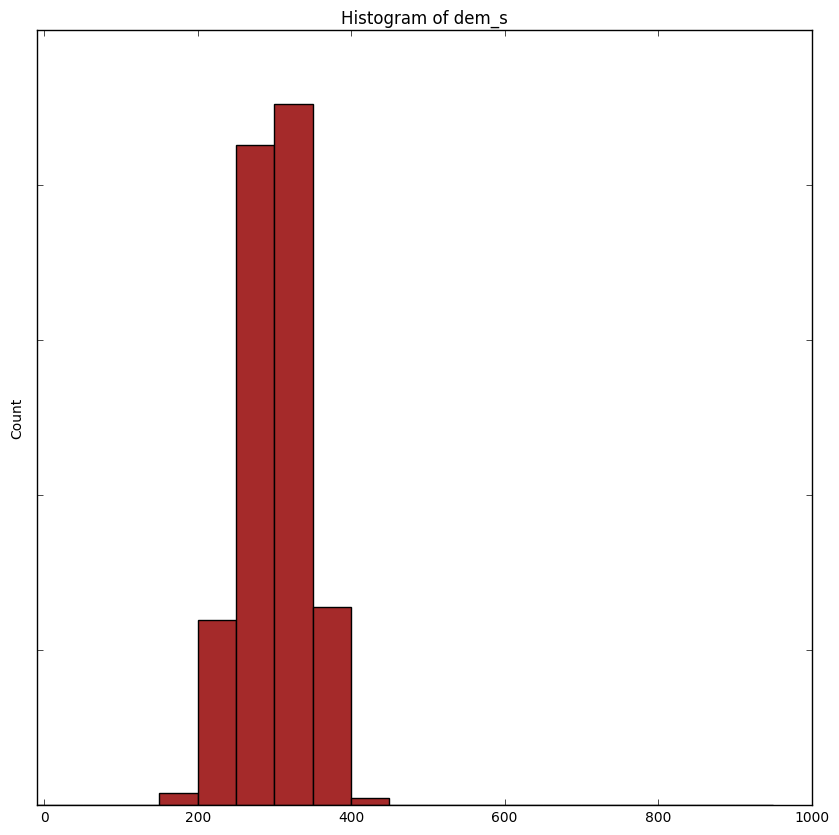

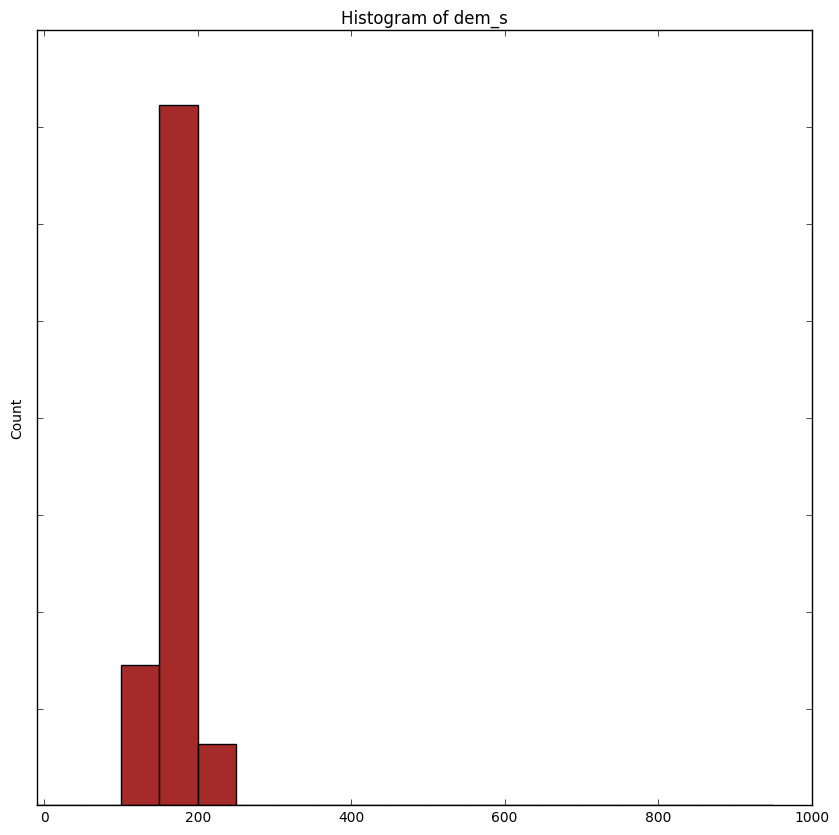

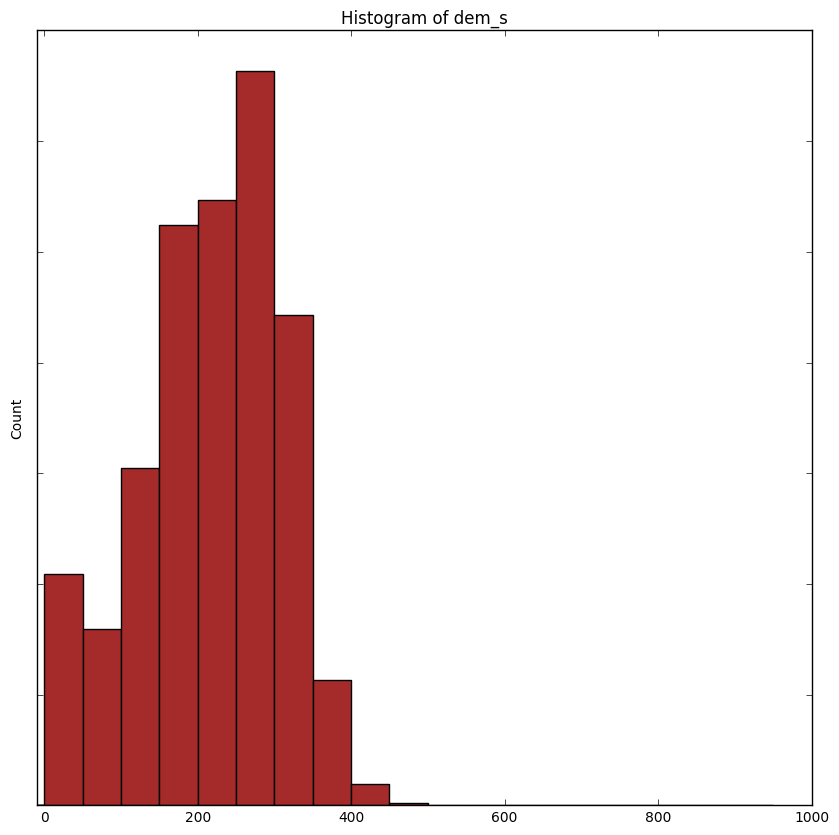

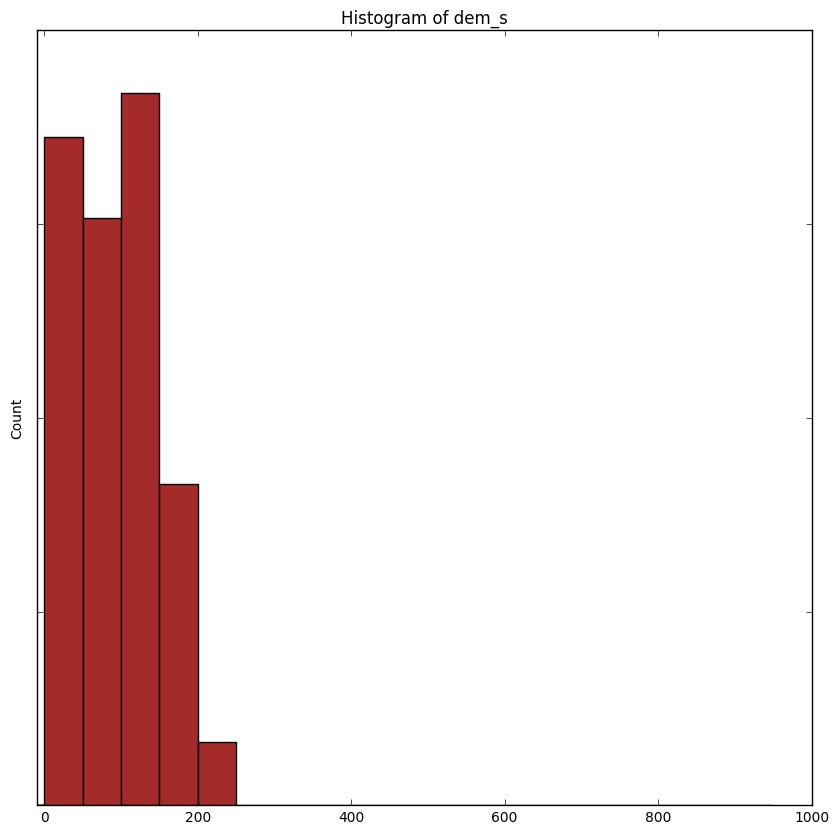

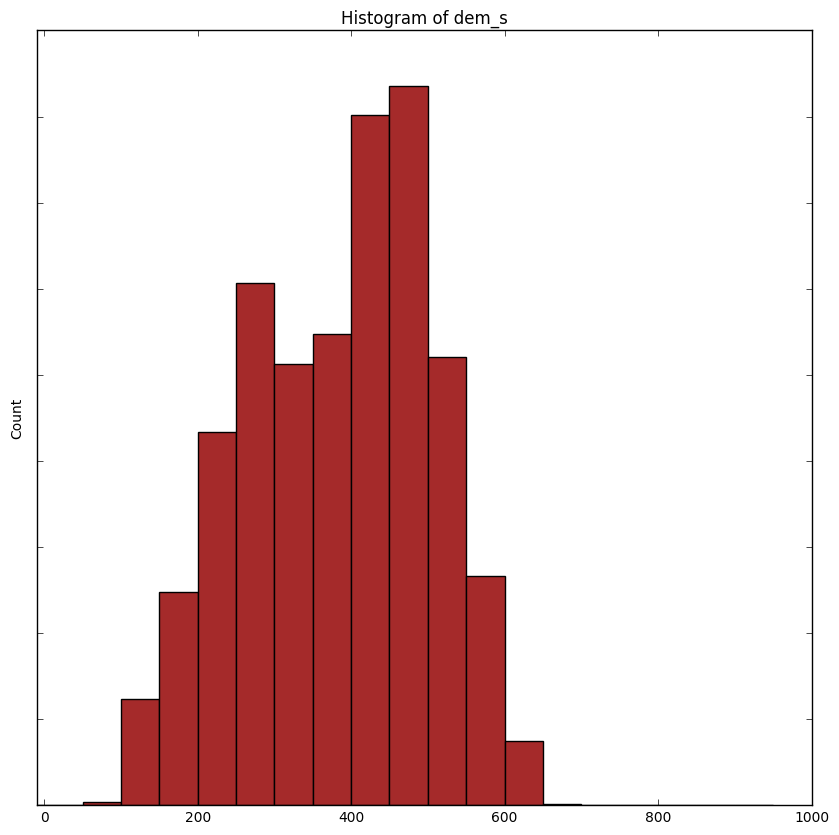

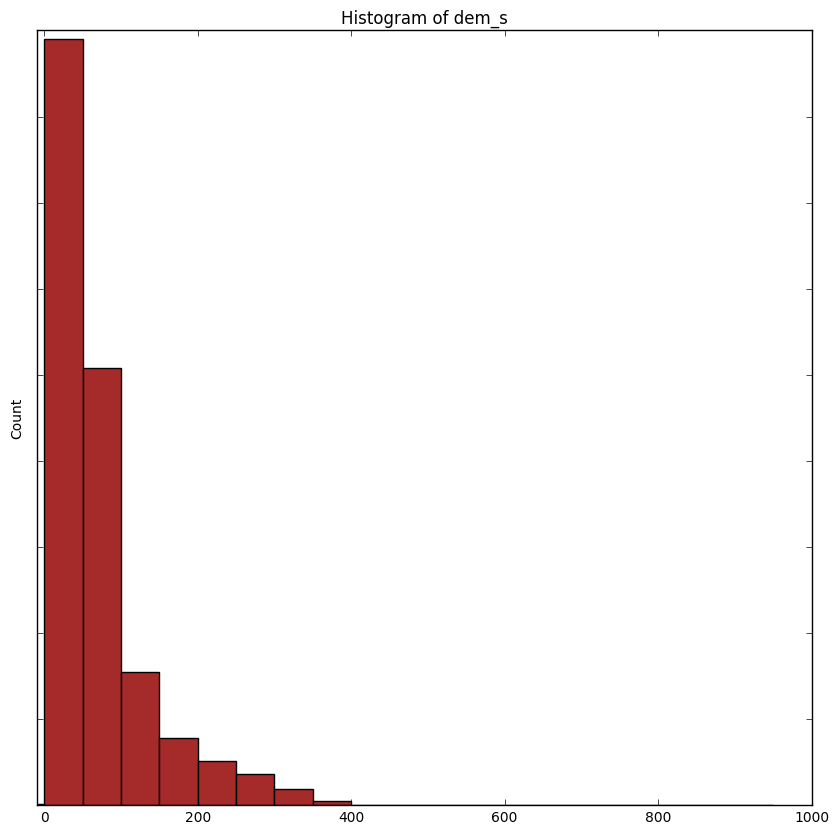

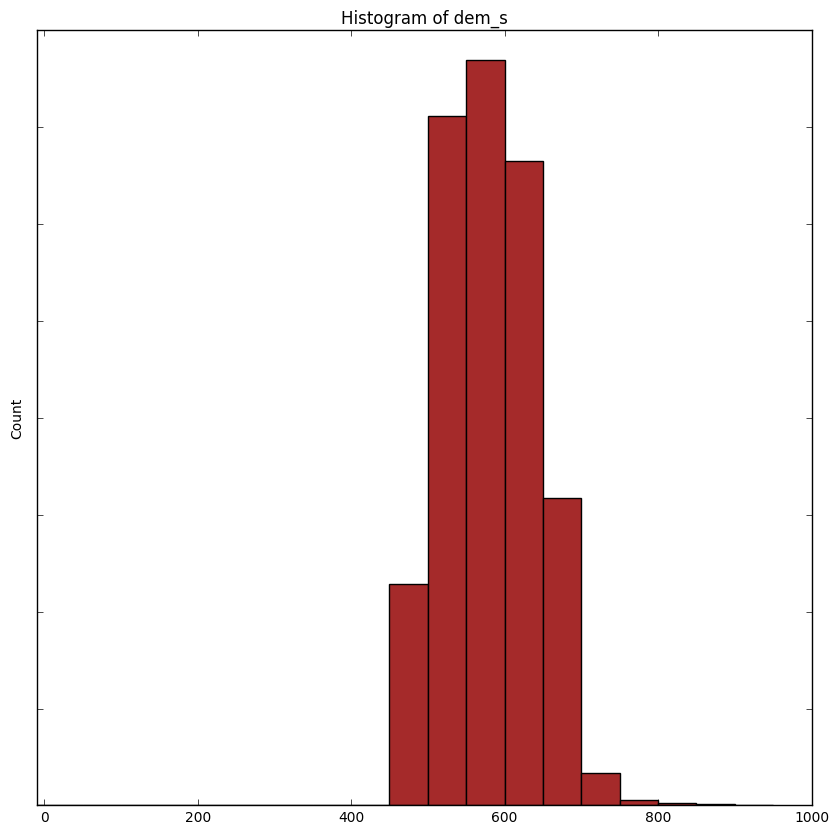

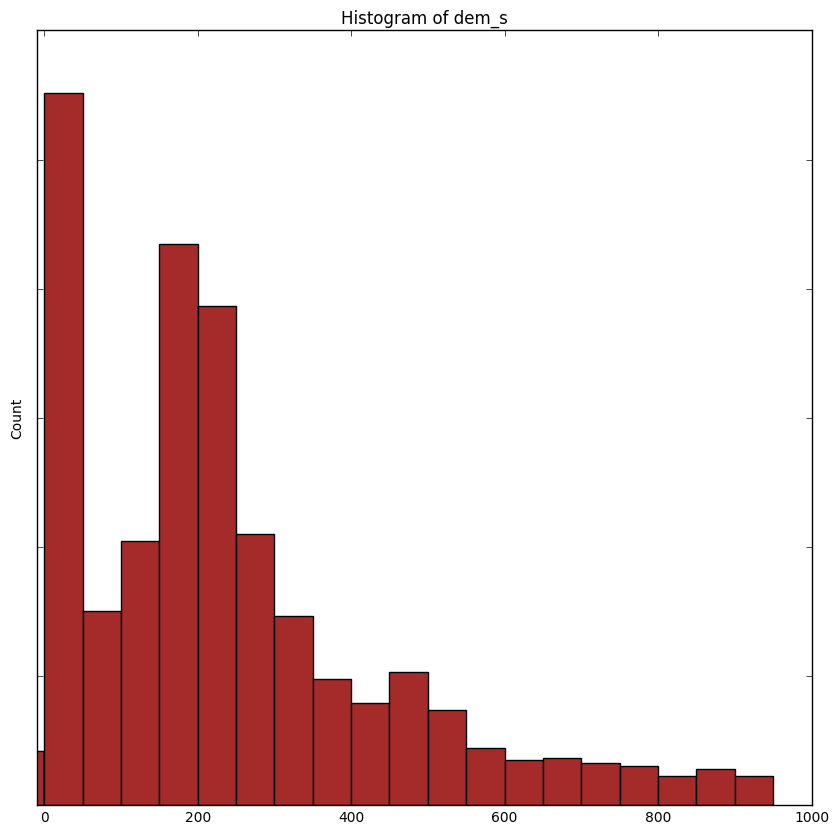

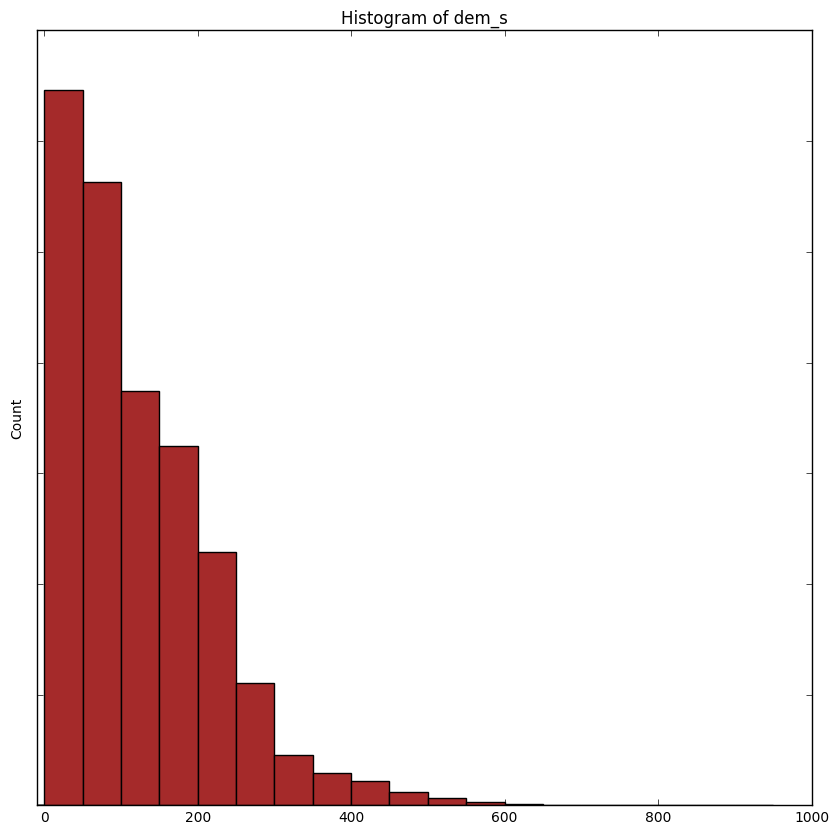

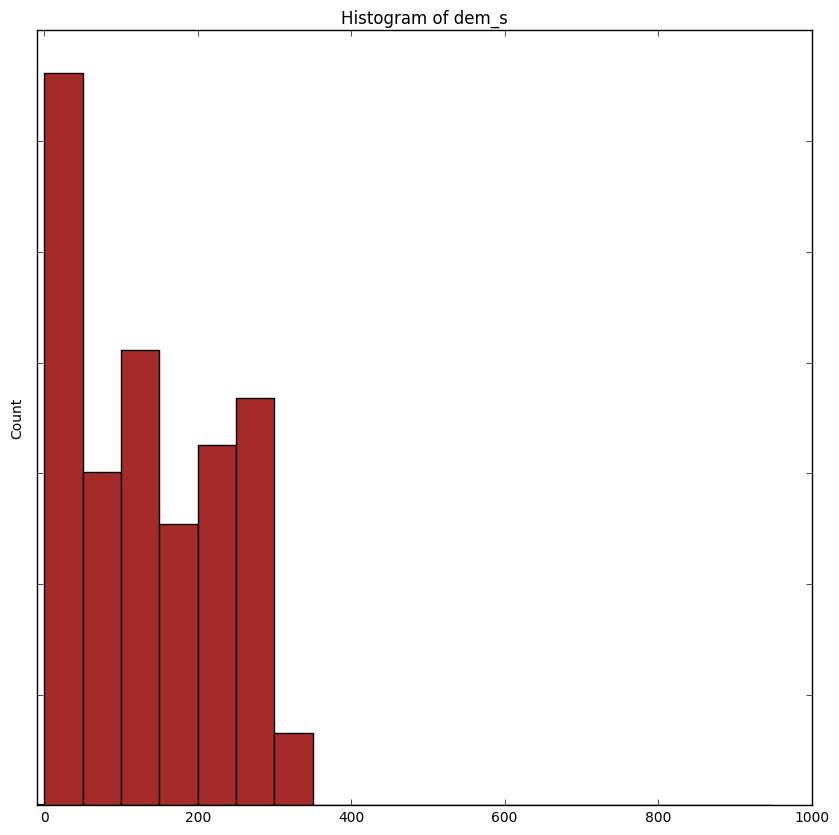

In [4]:
dc = datacube.Datacube(app='elevation_characterisation')

for num, site in enumerate(names.Name):
    Studysite = names.ix[num]
    print ('Working on ' + Studysite.Name)

    # Read in the elevation data from the datacube
    query = {'lat': (names.maxlat[num], names.minlat[num]), 
         'lon': (names.minlon[num], names.maxlon[num]),
         'resolution': (-250, 250), 'output_crs': 'EPSG:3577'}
    elev = dc.load(product = 'srtm_dem1sv1_0', group_by='solar_day', **query)
    minval = elev.dem_s.min()
    maxval = elev.dem_s.max()
    bin_values = np.arange(start = -50, stop = 1000, step = 50)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_ylabel('')
    #ax.set_xlabel('Elevation (m above sea level)')
    ax.set_yticklabels([])
    ax.set_xlim([-10, 1000])
    elev.dem_s.plot.hist(bins = bin_values, color = 'brown')

    #Let's save the plot
    fig.savefig('/g/data/p25/cek156/elevation/' + Studysite.Name + '_elevation.jpg', bbox_inches='tight')